## Pipeline SVM: Preprocesamiento, Búsqueda de Hiperparámetros y Evaluación

En las siguientes celdas se carga el dataset limpio, se define un pipeline que incluye preprocesamiento (escalado) y un clasificador SVM, se realiza búsqueda sistemática de hiperparámetros con `GridSearchCV`, y se evalúa el mejor modelo en un set de prueba. Se guardan resultados resumidos para extraer conclusiones.

In [32]:
# SVM pipeline: carga datos, preprocesado, GridSearch y evaluación
import json
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

TARGET_COL = 'Diabetes'
OUT_DIR = '../svm_results/'

df = pd.read_csv('../data/diabetes_train.csv') 
df_test = pd.read_csv('../data/diabetes_test.csv')


with open('../data/dictionary.json', 'r') as f:
    data_dict = json.load(f)

df.shape

(12500, 22)

In [33]:
pipe = Pipeline([
    ('clf', SVC(probability=True))
])

param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
    # 'clf__C': [1, 10],
    # 'clf__kernel': ['linear'],
    # 'clf__gamma': ['scale']
}

n_combinations = len(param_grid['clf__C']) * len(param_grid['clf__kernel']) * len(param_grid['clf__gamma'])
cv_folds = 5
total_fits = n_combinations * cv_folds

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv_folds,
    scoring='f1_macro'
    # n_jobs=1
    # verbose=0
)




In [34]:
X_train = df.drop(columns=[TARGET_COL])
y_train = df[TARGET_COL]

X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]

display(X_train.head())

,BMI,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartAttack,PhysActivity,Fruits,Veggies,...,HealthCare,Unaffordable_care,DiffWalk,Sex,GeneralHealth,MentalHealth,PhysicalHealth,Age,Education,Income
0,23.0,0,0,1,0,0,0,1,0,1,...,1,0,0,1,1,0,0,1,4,6
1,24.0,0,0,0,0,0,0,1,1,1,...,1,0,0,1,1,2,0,8,4,8
2,26.0,1,1,1,0,0,1,1,1,1,...,1,0,1,0,5,0,6,13,6,8
3,23.0,0,0,1,0,0,0,1,1,0,...,1,0,0,1,1,0,0,8,6,8
4,24.0,1,1,1,1,0,0,1,1,1,...,1,1,1,0,2,1,0,13,6,4


In [ ]:
grid.fit(X_train, y_train)

# Resultados
best = grid.best_estimator_

In [ ]:
print(f"\n✓ Mejores hiperparámetros encontrados:")
for param, value in grid.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\n✓ Mejor score CV (f1_macro): {grid.best_score_:.4f}")


✓ Mejores hiperparámetros encontrados:
  - clf__C: 0.1
  - clf__gamma: scale
  - clf__kernel: linear

✓ Mejor score CV (f1_macro): 0.7551


In [ ]:
# Guardar CV results
print("\n[5/5] Guardando resultados...")
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.to_csv(OUT_DIR + 'gridcv_results.csv', index=False)

print(y_test.shape[0])
# Evaluación en test set
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')


[5/5] Guardando resultados...
(50736,)


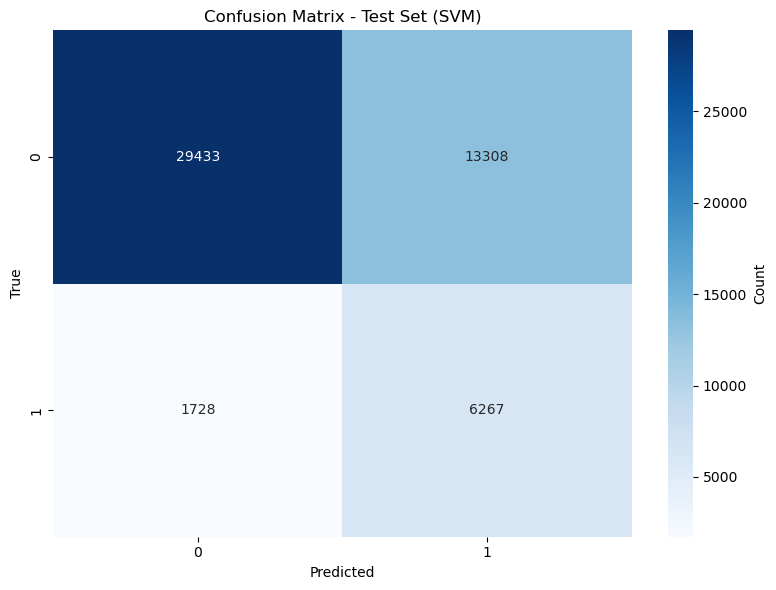

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set (SVM)')
plt.tight_layout()
plt.savefig(OUT_DIR + 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
print("\n" + "=" * 70)
print("MÉTRICAS EN CONJUNTO DE PRUEBA (TEST SET)")
print("=" * 70)
print(f"\n✓ Accuracy: {acc:.4f}")
print(f"✓ F1-Score (macro): {f1:.4f}")
print(f"\nReporte detallado por clase:")
print(classification_report(y_test, y_pred))


# Guardar resumen de métricas
summary = {
    'best_params': grid.best_params_,
    'cv_best_score_f1_macro': float(grid.best_score_),
    'test_accuracy': float(acc),
    'test_f1_macro': float(f1)
    }

with open(OUT_DIR + 'summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)


MÉTRICAS EN CONJUNTO DE PRUEBA (TEST SET)

✓ Accuracy: 0.7036
✓ F1-Score (macro): 0.6256

Reporte detallado por clase:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     42741
           2       0.32      0.78      0.45      7995

    accuracy                           0.70     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.85      0.70      0.74     50736

